# Can we beat the S&P 500

There's an entire industry devoted to this question. Can you beat the market? Usually the market is the S&P 500 which is a basket of the top 500 securities on the stock exchange weighted by market capitilization.

So for instance the S&P 500 contains stocks like AAPL, or GOOG weighted by how valuable each of those companies would theoretically sell for.

According to William Sharpe, Nobel Laureate and Fama and French really this whole exercise is dismal but perhaps we can come up with something better? In machine learning it's always important to try and see what comes out. Even if we can squeeze out an extra basis point (1/10th of a percent) our high net worth clients might pay us graciously for that!

# Forget about CRISP-DM focus on TACT

For my own work I have built my own method which is easier to remember called TACT. It's _very_ similar to CRISP-DM (which you should also look up). It stands for Target, Arrange, Compose, and Transmit.


We will be going through this process in the next two labs

# Target

What is our target? Make as much return as possible? Limit the volatility? Make the best risk adjusted return?

Sharpe Ratio?

Sortino Ratio?

Part of the difficulty with finance is that the optimization is very convex, very stochastic, and many times picking the right objective (or similar loss) is very very important!


If we were going to maximize return most likely we would pick one stock and stick with it, which isn't a great idea. If we were to lower volatility we'd probably just hold cash. Risk adjusted return is about balancing these two concerns and many times shows up in modern portfolio theory called mean variance optimization or MVO for short. 

This effectively tries to limit volatility subject to the return being high enough. That is a great method although really what we're interested in in more specific. We want to beat the S&P 500.

For that there are two major methods:

1. Sharpe ratio which is a measure of return above a risk free return (treasury bonds usually)
2. Sortino ratio. This is a modification of the sharpe ratio that minimizes downside risk of a portfolio
3. Tracking error. This one is subtle. We might want to match the S&P 500 as much as possible while minimizing trading. This shows how well we replicate the S&P 500.

# Arrange

I have taken care of most of the effort of arranging the data. Inside of the data folder is stock data going back from 2000 to 2012. Included in this is the ETF SPY which tracks the S&P 500 well.

Can you create a better sharpe ratio than the S&P 500 over the course of 2008-2012?

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from util import create_df_benchmark, get_data
from marketsim import compute_portvals_single_symbol, market_simulator
from strategy import StrategyLearner

In [2]:
train_start_date = dt.datetime(2007, 1, 1)
train_end_date   = dt.datetime(2007, 12, 31)
portfolio_start_date = dt.datetime(2008, 1, 1)
portfolio_end_date = dt.datetime(2008, 12, 31)

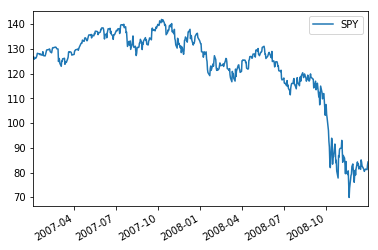

In [3]:
spy_df = get_data(['SPY'], pd.date_range(train_start_date, portfolio_end_date), addSPY=False)

spy_df.plot()

plt.show()

In [4]:
# What does the TBill rates look like over this time period?

In [5]:
# What does Sharpe Ratio look like for S&P 500?
from analysis import get_portfolio_value, get_portfolio_stats

port_val = get_portfolio_value(spy_df[['SPY']], 1.0, 10_000)

# Assuming 3% risk free return compounded over 252 days in a trading year
# Note APR = (1 + r)^252-1 so r = (1+APR)^(1/252) - 1
rfr = (1.03**(1/252.0))-1 

cr, adr, sddr, sr = get_portfolio_stats(port_val, rfr, 252.0)

"Sharpe Ratio over 2008-2012 is: {}".format(sr)

'Sharpe Ratio over 2008-2012 is: -0.5877984069089838'

# Compose the model

For this exercise we will be utilizing a Q-Learning strategy to optimize portfolios over time.

Q-Learning will learn a value Q within a given state given the actions.

So think of it like a table of actions you can take in a given state.

In [6]:
# Let's train up a portfolio given a really tough time market wise

train_start_date = dt.datetime(2007, 1, 1)
train_end_date   = dt.datetime(2007, 12, 31)
portfolio_start_date = dt.datetime(2008, 1, 1)
portfolio_end_date = dt.datetime(2008, 12, 31)

start_val = 100000
symbol = "SPY"
commission = 0.00
impact = 0.0
num_shares = 1000

df_benchmark_trades = create_df_benchmark(symbol, train_start_date, train_end_date, 
                                              num_shares)
print(df_benchmark_trades)

            Shares
Date              
2007-01-03    1000
2007-12-31   -1000


1 0.029300000000000104
2 0.010099999999999998
3 0.15280000000000005
4 0.15399999999999991
5 0.18419999999999992
6 0.18419999999999992
7 0.18419999999999992
8 0.18419999999999992
9 0.18419999999999992
10 0.18419999999999992
11 0.18419999999999992
12 0.18419999999999992
13 0.18419999999999992
14 0.18419999999999992
15 0.18419999999999992
16 0.18419999999999992
17 0.18419999999999992
18 0.18419999999999992
19 0.18419999999999992
20 0.18419999999999992
21 0.18419999999999992


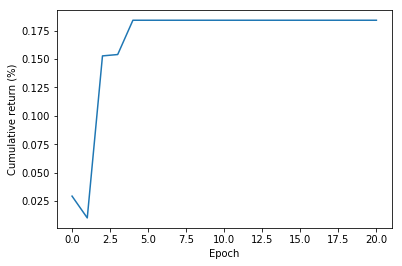

In [7]:
# Train and test a StrategyLearner
# Set verbose to True will print out and plot the cumulative return for each training epoch
from QLearner import QLearner
learner = QLearner(num_states=3000, num_actions=3)
stl = StrategyLearner(num_shares=num_shares, impact=impact, 
                      commission=commission, verbose=True,
                      learner=learner)
stl.add_evidence(symbol=symbol, start_val=start_val, 
                 start_date=train_start_date, end_date=train_end_date)
df_trades = stl.test_policy(symbol=symbol, 
                            start_date=train_start_date,
                            end_date=train_end_date)

Performances during training period for SPY
Date Range: 2007-01-01 00:00:00 to 2007-12-31 00:00:00
Sharpe Ratio of Portfolio: 0.2643672503706703
Sharpe Ratio of Benchmark : -0.6803344241208477

Cumulative Return of Portfolio: 0.028999999999999915
Cumulative Return of Benchmark : -0.4789

Standard Deviation of Portfolio: 0.02331613859579129
Standard Deviation of Benchmark : 0.04099177880652898

Average Daily Return of Portfolio: 0.00038829697913863654
Average Daily Return of Benchmark : -0.0017567863182126715

Final Portfolio Value: 102900.0
Final Benchmark Value: 52110.0


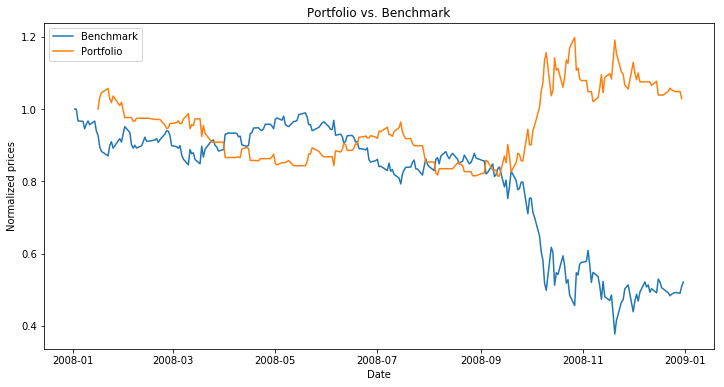

In [14]:
# Retrieve performance stats via a market simulator
print ("Performances during training period for {}".format(symbol))
print ("Date Range: {} to {}".format(train_start_date, train_end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)

In [15]:
df_benchmark_trades = create_df_benchmark(symbol, portfolio_start_date, portfolio_end_date, 
                                          num_shares)

In [16]:
df_trades = stl.test_policy(symbol=symbol, start_date=portfolio_start_date, 
                            end_date=portfolio_end_date)


Performances during testing period for SPY
Date Range: 2008-01-01 00:00:00 to 2008-12-31 00:00:00
Sharpe Ratio of Portfolio: 0.2643672503706703
Sharpe Ratio of Benchmark : -0.6803344241208477

Cumulative Return of Portfolio: 0.028999999999999915
Cumulative Return of Benchmark : -0.4789

Standard Deviation of Portfolio: 0.02331613859579129
Standard Deviation of Benchmark : 0.04099177880652898

Average Daily Return of Portfolio: 0.00038829697913863654
Average Daily Return of Benchmark : -0.0017567863182126715

Final Portfolio Value: 102900.0
Final Benchmark Value: 52110.0


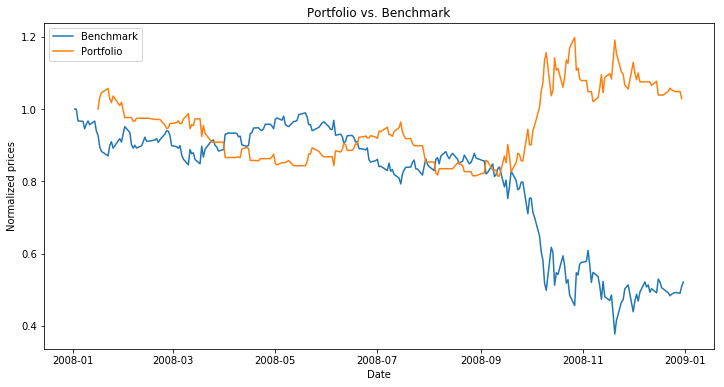

In [17]:
print ("\nPerformances during testing period for {}".format(symbol))
print ("Date Range: {} to {}".format(portfolio_start_date, portfolio_end_date))
market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact)

In [18]:
learner.memory

deque([(1565, 0, 0.004003323513860346, 223, False),
       (223, 0, 0.004989793603991766, 222, False),
       (222, 0, 0.005675877520537886, 454, False),
       (454, 2, 0.0, 1548, False),
       (1548, 1, 0.0, 1777, False),
       (1777, 1, 0.0, 1667, False),
       (1667, 1, 0.0, 1444, False),
       (1444, 1, 0.0, 1998, False),
       (1998, 1, 0.0, 1999, False),
       (1999, 1, 0.0, 1798, False),
       (1798, 1, 0.0, 1799, False),
       (1799, 1, 0.0, 1589, False),
       (1589, 1, 0.0, 1569, False),
       (1569, 1, 0.0, 1579, False),
       (1579, 1, 0.0, 1689, False),
       (1689, 1, 0.0, 1559, False),
       (1559, 1, 0.0, 1989, False),
       (1989, 1, 0.0, 1876, False),
       (1876, 1, 0.0, 1665, False),
       (1665, 1, 0.0, 1667, False),
       (1667, 1, 0.0, 1998, False),
       (1998, 1, 0.0, 1678, False),
       (1678, 1, 0.0, 1989, False),
       (1989, 1, 0.0, 1778, False),
       (1778, 1, 0.0, 1547, False),
       (1547, 1, 0.0, 1768, False),
       (1768, 1, 0.